In [1]:
import numpy as np
import syndat
import pandas as pd
import os
from matplotlib.pyplot import *
# import ATARI
from ATARI import PiTFAll as pf
import h5py
h5py.enable_ipython_completer()


In [2]:
%matplotlib widget

In [3]:
# Peformance Test for Fitting ALgorithm (PiTFALl)
# pd.__version__

In [4]:
# Initialize particle pair and quantup spin groups of interest

ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity [sic: perhaps, angular momentum?]
l_max = 1       # highest order l-wave to consider

spin_groups = [ (3.0,1,0) ] # (4.0,1,0) 
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })

Ta_pair = syndat.particle_pair( ac, M, m, I, i, l_max,
                                spin_groups=spin_groups, average_parameters=average_parameters,
                                input_options={})

In [5]:

# initialize experimental setup
E_min_max = [125, 150]
input_options = { 'Add Noise': True,
            'Sample TURP':True,
            'Sample TOCS':True, 
            'Calculate Covariance': True,
            'Compression Points':[],
            'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.1,    'unc'   :   0}}

exp = syndat.experiment(E_min_max, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)
print(len(exp.energy_domain))

199


In [6]:
# shift, penetration, phi, k = syndat.scattering_theory.FofE_explicit(np.linspace(3,2500,1000), Ta_pair.ac, Ta_pair.M, Ta_pair.m, 0)
# figure()
# plot(np.linspace(3,2500,1000), penetration)
# # 64/(2*np.mean(penetration))

In [7]:
# resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters)
# print(resonance_ladder)
# # resonance_ladder.to_csv()

# xs_tot, xs_scat, xs_cap = syndat.scattering_theory.SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
# n = 0.067166 
# trans = np.exp(-n*xs_tot)
# trans_thick = np.exp(-0.5*xs_tot)
# theoretical_df = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':trans})

# fig, ax = subplots(1,2, figsize=(10,4))
# ax[0].plot(exp.energy_domain, xs_tot)
# ax[0].set_title('Total Cross Section')
# ax[0].legend()
# ax[0].set_yscale('log')

# ax[1].plot(theoretical_df.E, theoretical_df.theo_trans, '.', ms=1)
# ax[1].set_xscale('log')
# ax[1].set_ylim([0,1])
# ax[1].set_title('Transmission')

# fig.supxlabel('Energy (eV)')

In [8]:
# run a performance test with the PiTFAll module
case_file = '/Users/noahwalton/Documents/GitHub/ATARI/Fitting/perf_test_staticladder.hdf5'
static_resonance_ladder = pd.read_hdf(case_file, 'sample_0/theo_par')
dataset_range = (0, 500)

path_to_application_exe = '/Applications/MATLAB_R2021b.app/bin/matlab'
path_to_fitting_script = "/Users/noahwalton/Documents/GitHub/ATARI/baron_fit_rev1.m"

vary_Erange = None

input_options = {   'Overwrite Syndats'    :   False, 
                    'Overwrite Fits'       :   False,
                    'Use HDF5'             :   True,
                    'Vary Erange'          :   vary_Erange} 



perf_test = pf.performance_test(dataset_range,
                                case_file,
                                input_options=input_options)

sample_data_df, out = perf_test.generate_syndats(Ta_pair, exp, 
                                                    solver='syndat_SLBW',
                                                    fixed_resonance_ladder=static_resonance_ladder)
print(out)

User chose to NOT overwrite previously generated datasets in the file /Users/noahwalton/Documents/GitHub/ATARI/Fitting/perf_test_staticladder.hdf5.
Samples  0-500 already existed.
Samples 500-500 were generated.
If Syndat generation settings were changed these files should be overwriten.


In [9]:
# import h5py
with h5py.File(case_file, 'r') as f:
    print(f['sample_499'].keys())
    f.close()

<KeysViewHDF5 ['est_par_baron_rev1', 'est_par_baron_rev1_pp', 'est_par_baron_rev2', 'est_par_baron_rev2_pp', 'est_par_baron_rev3', 'est_par_baron_rev3_pp', 'est_par_pswarm_rev1', 'est_par_pswarm_rev1_pp', 'exp_cov', 'exp_pw', 'poles', 'theo_par', 'theo_pw']>


In [10]:
print(f"Average # Resonances: {np.mean(sample_data_df.NumRes)}")
print(f"Min/Max # Resonances: {np.min(sample_data_df.NumRes)}/{np.max(sample_data_df.NumRes)}")

print(f"Average Energy Points: {np.mean(sample_data_df.NumEpts)}")
print(f"Min/Max Energy Points: {np.min(sample_data_df.NumEpts)}/{np.max(sample_data_df.NumEpts)}")

print(f"Min theoretical SE: {np.min(sample_data_df.theo_exp_SE)}")

# sample_0

Average # Resonances: 4.0
Min/Max # Resonances: 4/4
Average Energy Points: 199.0
Min/Max Energy Points: 199/199
Min theoretical SE: 0.14719440594966635


In [11]:
out = perf_test.generate_fits(False)
print(out)

User chose to NOT run the fitting algorithm locally.
The data file /Users/noahwalton/Documents/GitHub/ATARI/Fitting/perf_test_staticladder.hdf5 has been prepared based on the selected overwrite options.
Please run samples 0-500


In [12]:
f = h5py.File(case_file, 'r+')
# del f['sample_0']['fit_par']
# print(f['sample_0/est_par_baron'])
# print(f['sample_10/exp_cov'][()])
print(f['sample_0'].keys())
# print(f['test_stats/sample_data'].keys())
f.close()
# pd.read_hdf(case_file, 'sample_0/exp_pw')
# pd.read_hdf(case_file, 'sample_0/theo_par')

<KeysViewHDF5 ['est_par_baron_rev1', 'est_par_baron_rev1_pp', 'est_par_baron_rev2', 'est_par_baron_rev2_pp', 'est_par_baron_rev3', 'est_par_baron_rev3_pp', 'est_par_pswarm_rev1', 'est_par_pswarm_rev1_pp', 'exp_cov', 'exp_pw', 'poles', 'theo_par', 'theo_pw']>


### Analyze all fits

In [13]:
fit_names = ['baron_rev1','baron_rev2','baron_rev3', 'pswarm_rev1', 'baron_rev1_pp','baron_rev2_pp','baron_rev3_pp', 'pswarm_rev1_pp']
all_fits = {}
for fit_name in fit_names:
    integral_pw_FoMs_df, integral_par_FoMs_df, bv_window_df, (bv_pw_xs_df, bv_pw_trans_df), sample_data_df, printout = perf_test.analyze(Ta_pair, exp, fit_name)
    # print(printout)
    all_fits[fit_name] = pf.fit(fit_name, integral_pw_FoMs_df, integral_par_FoMs_df, bv_window_df, bv_pw_xs_df, bv_pw_trans_df, sample_data_df, printout)


## Filter specific fits

In [46]:
## filter to cases we want
fits = {}
# fits = {k: v for k, v in all_fits.items() if k in ['baron_rev1','baron_rev2','baron_rev3', 'pswarm_rev1']}
# fits = {k: v for k, v in all_fits.items() if k in ['pswarm_rev1','pswarm_rev1_pp']}
fits = {k: v for k, v in all_fits.items() if k in ['baron_rev2','baron_rev2_pp']}
# fits = {k:all_fits[k] for k in ['baron_rev1','baron_rev1_pp','baron_rev2','baron_rev2_pp','baron_rev3','baron_rev3_pp',  'pswarm_rev1', 'pswarm_rev1_pp']}

In [47]:

print('integral_FoMs : ')
print(fits[list(fits.keys())[0]].integral_FoMs.keys())

# [print(key) for key in fits.keys()]


integral_FoMs : 
Index(['fit_theo_MSE', 'fit_exp_SE', 'fit_exp_chi2', 'fit_exp_chi2dof',
       'theo_exp_SE', 'theo_exp_chi2', 'theo_exp_chi2dof', 'tfit'],
      dtype='object')


### Compare Figures of Merit

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/PiTFAll/pf_plot.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


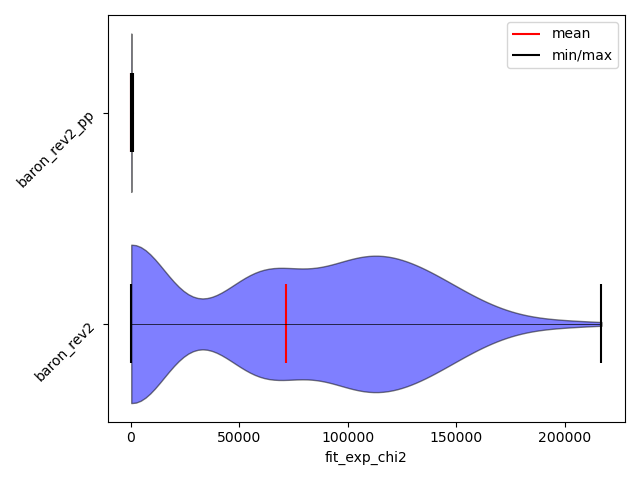

In [49]:
fom = 'fit_exp_chi2' #'fit_exp_chi2'

violin_data = [fits[key].integral_FoMs[fom] for key in fits.keys()]
violin_labels = fits.keys()
# violin_colors = ['blue', 'orange', 'green', 'yellow']
violin_colors = ['blue','blue', 'orange','orange', 'green','green', 'yellow','yellow']


fig = pf.pf_plot.violin(violin_data, violin_labels, violin_colors, fom)


### Histogram for bias/variance over a window

In [50]:
# print('bv_pw_inwindow : ')
# print(fits[fit_names[0]].bv_window.keys())

In [51]:
# fom = 'window_bias_xs'

# violin_data = [fits[key].bv_window[fom] for key in fits.keys()]
# violin_labels = fits.keys()
# violin_colors = ['blue', 'orange', 'green', 'yellow']

# fig = pf.pf_plot.violin(violin_data, violin_labels, violin_colors, fom)

### Bias/variance pointwise for static window

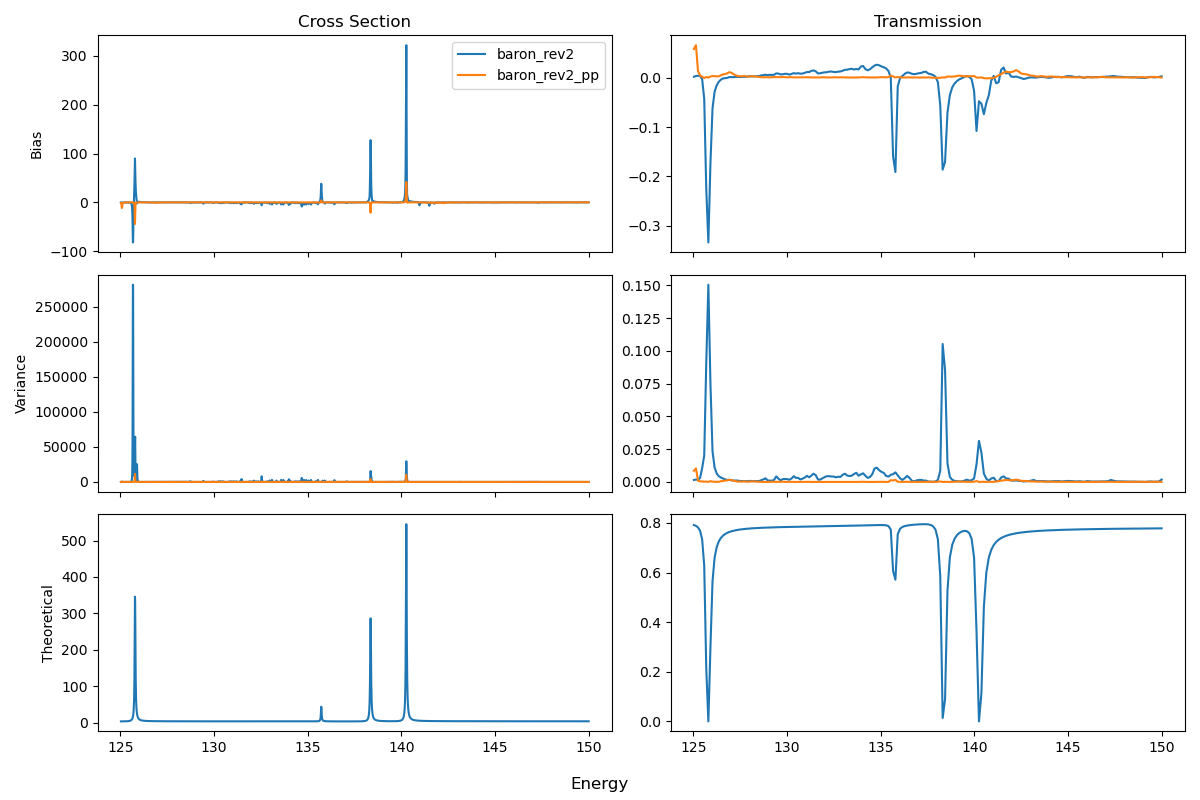

In [52]:

fig, (ax1, ax2, ax3) = subplots(3,2, figsize=(12,8), sharex=True)
a = 1
for key in fits.keys():
    ax1[0].plot(fits[key].bv_pw_xs_df['E'],fits[key].bv_pw_xs_df['bias'], label=key,alpha=a)
    ax1[1].plot(fits[key].bv_pw_trans_df['E'],fits[key].bv_pw_trans_df['bias'], label=key,alpha=a)
    ax2[0].plot(fits[key].bv_pw_xs_df['E'],fits[key].bv_pw_xs_df['variance'], label=key,alpha=a)
    ax2[1].plot(fits[key].bv_pw_trans_df['E'],fits[key].bv_pw_trans_df['variance'], label=key,alpha=a)
    # a += -0.25
ax1[0].legend()
exp_pw_df, theo_pw_df = pf.sample_case.read_pw_datasets(case_file, 0)
ax3[0].plot(theo_pw_df.E, theo_pw_df.theo_xs)
ax3[1].plot(exp_pw_df.E, exp_pw_df.theo_trans)

# ax[0].legend(); ax[1].legend()
ax1[0].set_ylabel('Bias')
ax2[0].set_ylabel('Variance')
ax3[0].set_ylabel('Theoretical')

ax1[0].set_title('Cross Section'); ax1[1].set_title('Transmission')
fig.supxlabel('Energy')

fig.tight_layout()

Text(0.5, 0, 'Bias')

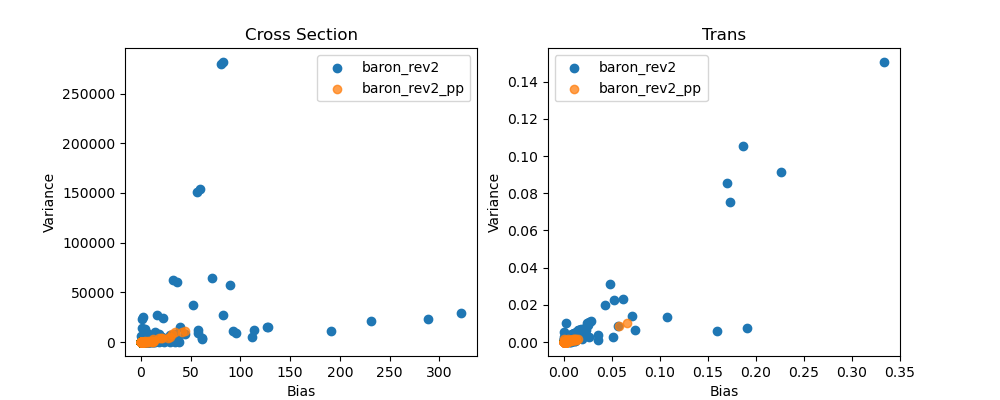

In [55]:

fig, ax = subplots(1,2, figsize=(10,4))
a = 1
for key in fits.keys():
    ax[0].scatter(abs(fits[key].bv_pw_xs_df['bias']),fits[key].bv_pw_xs_df['variance'], label=key,alpha=a)
    ax[1].scatter(abs(fits[key].bv_pw_trans_df['bias']),fits[key].bv_pw_trans_df['variance'], label=key,alpha=a)
    a += -0.25

ax[0].set_title('Cross Section'); ax[1].set_title('Trans')
ax[0].legend(); ax[1].legend()
ax[0].set_ylabel('Variance'); ax[1].set_ylabel('Variance')
ax[0].set_xlabel('Bias'); ax[1].set_xlabel('Bias')

In [21]:
print('integral_par_FoMs : ')
print(fits[list(fits.keys())[0]].integral_par_FoMs.keys())
print('syndat_data : ')
print(fits[list(fits.keys())[0]].syndat_data.keys())

integral_par_FoMs : 
Index(['est_card', 'est_avg_Gg', 'est_avg_gnx2', 'est_min_Gg', 'est_min_gnx2',
       'est_max_Gg', 'est_max_gnx2'],
      dtype='object')
syndat_data : 
Index(['NumRes', 'NumEpts', 'theo_exp_SE', 'theo_avg_gnx2', 'theo_avg_Gg',
       'theo_min_gnx2', 'theo_min_Gg', 'theo_max_gnx2', 'theo_max_Gg'],
      dtype='object')


### Trends

In [56]:
fits[list(fits.keys())[0]].joined_df.keys()

Index(['fit_theo_MSE', 'fit_exp_SE', 'fit_exp_chi2', 'fit_exp_chi2dof',
       'theo_exp_SE', 'theo_exp_chi2', 'theo_exp_chi2dof', 'tfit', 'est_card',
       'est_avg_Gg', 'est_avg_gnx2', 'est_min_Gg', 'est_min_gnx2',
       'est_max_Gg', 'est_max_gnx2', 'WE_midpoint', 'bias_xs', 'bias_trans',
       'variance_xs', 'variance_trans', 'NumRes', 'NumEpts', 'theo_exp_SE',
       'theo_avg_gnx2', 'theo_avg_Gg', 'theo_min_gnx2', 'theo_min_Gg',
       'theo_max_gnx2', 'theo_max_Gg'],
      dtype='object')

Text(0.5, 0, 'variance_trans')

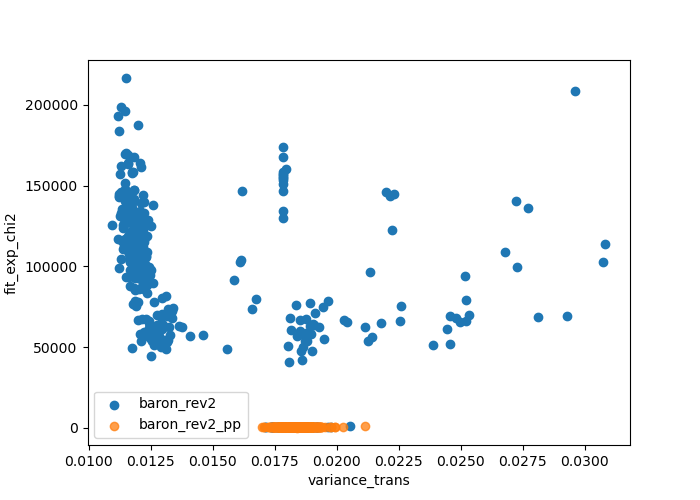

In [60]:
x = 'variance_trans'
y = 'fit_exp_chi2'

figure(figsize=(7,5))
a = 1
for key in fits.keys():
    scatter(fits[key].joined_df[x],fits[key].joined_df[y], label=key,alpha=a)
    a += -0.25

legend()
ylabel(y)
xlabel(x)
# xlim([-10,50])
# ylim([-10,40000])

### Correlations

In [24]:
# FoM_of_interest = ['fit_theo_MSE', 'fit_exp_chi2', 'fit_exp_chi2dof', 'fit_exp_SE']#,'tfit','NumEpts','NumRes', 'est_card']
# # FoM_of_interest = ['tfit', 'fit_theo_MSE', \
# #                    'est_avg_Gg', 'est_avg_gnx2', 'est_min_Gg', 'est_min_gnx2','est_max_Gg', 'est_max_gnx2', \
# #                    'theo_avg_Gg', 'theo_avg_gnx2', 'theo_min_Gg', 'theo_min_gnx2', 'theo_max_Gg', 'theo_max_gnx2']

# filtered_joined_df_baron_rev1 = joined_df_baron_rev1[FoM_of_interest]
# filtered_joined_df_baron_rev2 = joined_df_baron_rev2[FoM_of_interest]
# filtered_joined_df_pswarm_rev1 = joined_df_pswarm_rev1[FoM_of_interest]
# filtered_joined_df_pswarm_pp_rev1 = joined_df_pswarm_pp_rev1[FoM_of_interest]

In [25]:
# correlation_baron_rev1 = filtered_joined_df_baron_rev1.corr()
# correlation_baron_rev2 = filtered_joined_df_baron_rev2.corr()
# correlation_pswarm_rev1 = filtered_joined_df_pswarm_rev1.corr()
# correlation_pswarm_pp_rev1 = filtered_joined_df_pswarm_pp_rev1.corr()

# fig, ax = subplots(1,4, figsize=(11,6), sharey=True, constrained_layout=True)


# im1 = ax[0].imshow(correlation_baron_rev1, vmin=-1, vmax=1); ax[0].set_title('baron_rev1')
# im2 = ax[1].imshow(correlation_baron_rev2, vmin=-1, vmax=1); ax[1].set_title('baron_rev2')
# im3 = ax[2].imshow(correlation_pswarm_rev1, vmin=-1, vmax=1); ax[2].set_title('pswarm_rev1')
# im3 = ax[3].imshow(correlation_pswarm_pp_rev1, vmin=-1, vmax=1); ax[3].set_title('pswarm_pp_rev1')

# from mpl_toolkits.axes_grid1 import make_axes_locatable

# for axis in ax:
#     axis.set_xticks(range(len(filtered_joined_df_pswarm_rev1.keys())))
#     axis.set_xticklabels([filtered_joined_df_pswarm_rev1.keys()[i] for i in range(len(filtered_joined_df_pswarm_rev1.keys()))], fontsize=7, rotation=-80)
#     axis.set_yticks(range(len(filtered_joined_df_pswarm_rev1.keys())))
#     axis.set_yticklabels([filtered_joined_df_pswarm_rev1.keys()[i] for i in range(len(filtered_joined_df_pswarm_rev1.keys()))], fontsize=7, rotation=0)

#     # divider = make_axes_locatable(axis)
#     # cax = divider.append_axes("right", size="5%", pad=0.05)
#     # colorbar(im3, cax=cax)

# # fig.subplots_adjust(wspace=0.1)
# fig.colorbar(im2, ax=ax[3], shrink=0.5)
# # legend()
# # tight_layout()

# # divider = make_axes_locatable(ax[2])
# # cax = divider.append_axes("right", size="5%", pad=0.05)
# # colorbar(im3, cax=cax)

# # cb.set_clim(-1.0, 1.0)
# # cb.ax.tick_params(labelsize=10)
# # title('FoM Correlation', fontsize=10)

### Other statistics

In [61]:
print("Fits with a smaller exp_chi2 than True:")
# [fits[key].bv_pw_inwindow[fom] for key in fits.keys()]
for key in fits.keys():
    print(f"{key}: {np.count_nonzero(fits[key].integral_FoMs['fit_exp_chi2']<fits[key].integral_FoMs['theo_exp_chi2'])/len(fits[key].integral_FoMs)}" )

print()
print("Fits with a smaller exp_SE than True:")
for key in fits.keys():
    print(f"{key}: {np.count_nonzero(fits[key].integral_FoMs['fit_exp_SE']<fits[key].integral_FoMs['theo_exp_SE'])/len(fits[key].integral_FoMs)}" )


Fits with a smaller exp_chi2 than True:
baron_rev2: 0.0
baron_rev2_pp: 0.032

Fits with a smaller exp_SE than True:
baron_rev2: 0.0
baron_rev2_pp: 0.142


### Interrogate individual cases

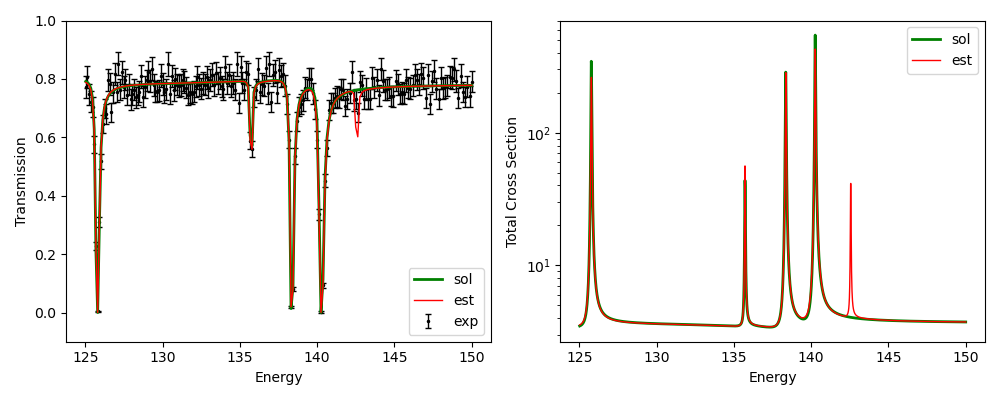

In [66]:
fig = pf.sample_case.plot(case_file, 29, 'baron_rev2_pp')

### Next steps

1) Analyze statistics on resonance parameters

    a) how do we quantify missing or misassigned resonances?
    
    b) can we build a correlation between accuracy and width? perhaps energy resolution should be considered.

2) Incude relationship between magnitude of unc/correlation and fit

3) maybe look at variance in theo or est resonance parameters rather than average/min/max

4) do a performance test without a moving window, and/or with a constant resonance ladder. These will allow for different performance metrics to be built such as:
    a) Bias-variance plot with a different interpretation
    b) Influence of energy points per resonance (different that #epts/#res, must consider the width of influence per resonance)
    c) Quantification of performance as it relates to location within the window without - though this analysis could be done in the above examples but we would need to parameterize the location within the window since erange and epts are changing... perhaps relative distance from centerpoint

5) do not recalculate integral FoM's if they are already calculated and saved in case file

### Dev code below

Improvements:
- store (exp.redpar - exp.theo_redpar) for each sample to see effects of large changes in true underlying reduction parameters
- characterize relationship between pw FoMs and resonance widths/location
- compare est/theo parameter dataframes 
- 

            E         Gg       gnx2    J  chs  lwave  J_ID
0  125.780233  46.877272  46.904461  3.0  1.0    0.0   1.0
1  135.723866  43.301260   5.037288  3.0  1.0    0.0   1.0
2  138.358139  50.444624  44.088821  3.0  1.0    0.0   1.0
3  140.263671  46.030202  77.271446  3.0  1.0    0.0   1.0
            E         Gg       gnx2
0  125.776288  30.886619  67.942785
1  130.971972   2.709602   6.316821
2  134.132209   7.120743   2.743237
3  138.358225  55.489086  40.194537
4  140.262861  54.236202  68.945774


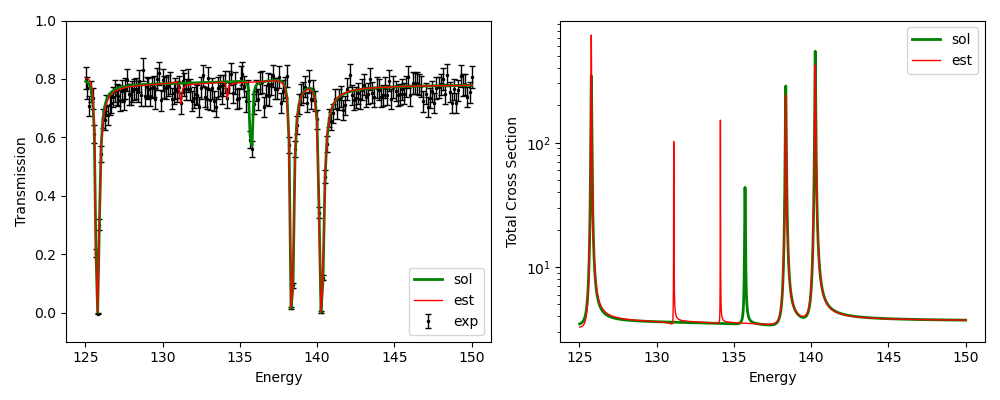

In [28]:
fit_name = 'pswarm_rev1'

isample = 1


fig = pf.sample_case.plot(case_file, isample, fit_name)

exp_pw_df, theo_pw_df, theo_par_df, est_par_df, exp_cov = pf.sample_case.read_sample_case_data(case_file, isample, fit_name)

# trans = np.exp(-0.06*theo_pw_df.theo_xs)
# figure()
# plot(theo_pw_df.E, trans)

est_par_df_nonzero = est_par_df.loc[est_par_df['gnx2']>0.0, 'E':'gnx2']
theo_par_df.sort_values('E', ignore_index=True, inplace=True)
est_par_df_nonzero.sort_values('E', ignore_index=True, inplace=True)


print(theo_par_df)
# print(est_par_df) 
print(est_par_df_nonzero)

### Similarity Coefficient and L2 norm per resonance

9.1304979493278e-05
222.2544120811414


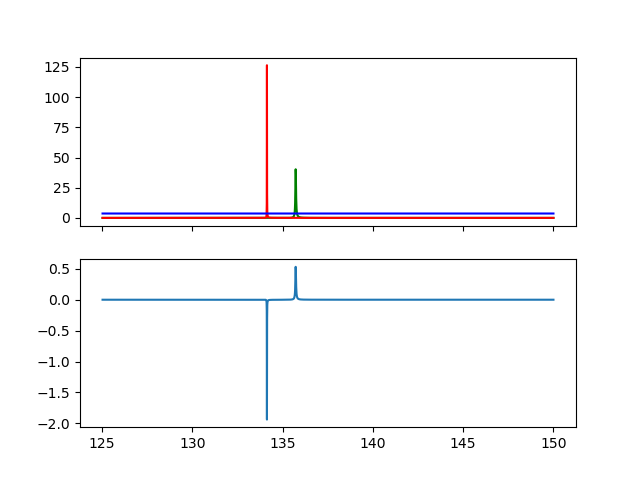

In [29]:

def single_resonance_pw(i_est, i_theo, theo_par_df, est_par_df_nonzero, energy, particle_pair):
    theo_single_resonance_df = theo_par_df.loc[[i_theo]]
    est_single_resonance_df = pf.sample_case.take_syndat_spingroups(theo_par_df, est_par_df_nonzero.loc[[i_est]])
    est_xs_tot, _, _ = syndat.scattering_theory.SLBW(energy, particle_pair, est_single_resonance_df)
    theo_xs_tot, _, _ = syndat.scattering_theory.SLBW(energy, particle_pair, theo_single_resonance_df)
    return est_xs_tot, theo_xs_tot 


lwave=0; Jpi=3.0
window_shift, window_penetration, window_phi, window_k = syndat.scattering_theory.FofE_explicit(theo_pw_df.E, Ta_pair.ac, Ta_pair.M, Ta_pair.m, lwave)
g = syndat.scattering_theory.gstat(Jpi, Ta_pair.I, Ta_pair.i)
potential_scattering = (4*np.pi*g/(window_k**2)) * np.sin(window_phi)**2

# visualize a single case
est_xs_tot, theo_xs_tot = single_resonance_pw(2, 1, theo_par_df, est_par_df_nonzero, theo_pw_df.E, Ta_pair)
est_xs_tot  -= potential_scattering
theo_xs_tot -= potential_scattering 

product_integral = np.trapz(est_xs_tot*theo_xs_tot, x=theo_pw_df.E)
normalization = np.sqrt( np.trapz(est_xs_tot**2, x=theo_pw_df.E)*np.trapz(theo_xs_tot**2, x=theo_pw_df.E) )
L2_norm = np.trapz((theo_xs_tot-est_xs_tot)**2, theo_pw_df.E)

print(product_integral/normalization)
print(L2_norm)

fig, ax = subplots(2,1, sharex=True)
ax[0].plot(theo_pw_df.E, theo_xs_tot, 'g')
ax[0].plot(theo_pw_df.E, est_xs_tot, 'r')
ax[0].plot(theo_pw_df.E, potential_scattering, 'b')
ax[1].plot(theo_pw_df.E, theo_xs_tot*est_xs_tot)
# ax[0].set_yscale('log')


In [30]:
def calc_sim_L2_matrix(case_file, isample, fit_name):

    theo_par_df, est_par_df = pf.sample_case.read_par_datasets(case_file, isample, fit_name)

    est_par_df_nonzero = est_par_df.loc[est_par_df['gnx2']>0.0, 'E':'gnx2']
    theo_par_df.sort_values('E', ignore_index=True, inplace=True)
    est_par_df_nonzero.sort_values('E', ignore_index=True, inplace=True)


    resonance_similarity_matrix = np.zeros((len(est_par_df_nonzero),len(theo_par_df)))
    L2_norm_matrix = np.zeros((len(est_par_df_nonzero),len(theo_par_df)))
    pairs = []

    # window potential scattering
    lwave=0; Jpi=3.0
    window_shift, window_penetration, window_phi, window_k = syndat.scattering_theory.FofE_explicit(theo_pw_df.E, Ta_pair.ac, Ta_pair.M, Ta_pair.m, lwave)
    g = syndat.scattering_theory.gstat(Jpi, Ta_pair.I, Ta_pair.i)
    potential_scattering = (4*np.pi*g/(window_k**2)) * np.sin(window_phi)**2

    energy = np.array(theo_pw_df.E)
    particle_pair = Ta_pair

    for i_est in range(len(est_par_df_nonzero)):
        est_single_resonance_df = pf.sample_case.take_syndat_spingroups(theo_par_df, est_par_df_nonzero.loc[[i_est]])
        est_xs_tot, _, _ = syndat.scattering_theory.SLBW(energy, particle_pair, est_single_resonance_df)
        est_xs_tot  -= potential_scattering
        
        for i_theo in range(len(theo_par_df)):
            theo_single_resonance_df = theo_par_df.loc[[i_theo]]
            theo_xs_tot, _, _ = syndat.scattering_theory.SLBW(energy, particle_pair, theo_single_resonance_df)
            theo_xs_tot -= potential_scattering 

            product_integral = np.trapz(est_xs_tot*theo_xs_tot, x=energy)
            normalization = np.sqrt( np.trapz(est_xs_tot**2, x=energy)*np.trapz(theo_xs_tot**2, x=energy) )

            similarity = product_integral/normalization
            # similarity = max(0, similarity) 
            resonance_similarity_matrix[i_est, i_theo] = similarity

            L2_norm = np.trapz((theo_xs_tot-est_xs_tot)**2, energy)
            L2_norm_matrix[i_est, i_theo] = L2_norm

            pairs.append((similarity, L2_norm))

    pairs = np.array(pairs)

    return resonance_similarity_matrix, L2_norm_matrix, pairs

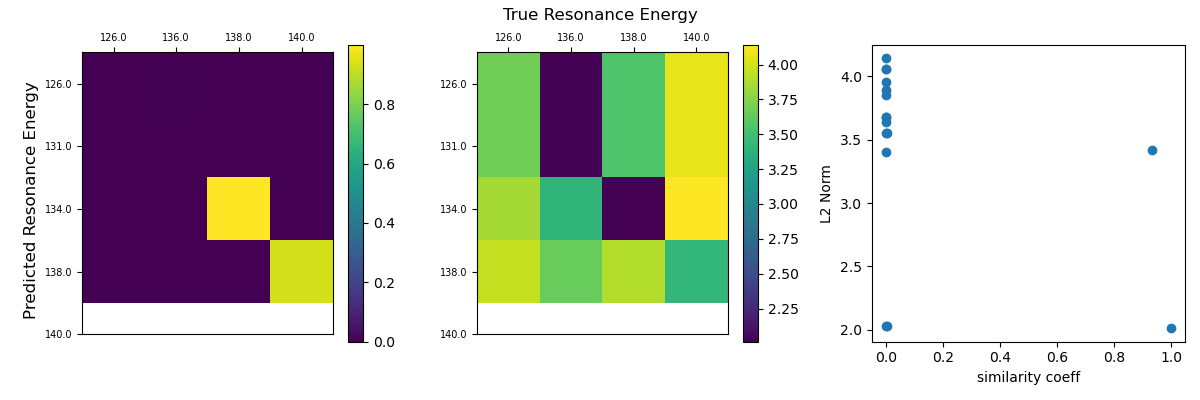

In [31]:
isample = 0
fit_name = 'baron_rev1'

resonance_similarity_matrix, L2_norm_matrix, pairs = calc_sim_L2_matrix(case_file, isample, fit_name)


fig, ax = subplots(1,3, figsize=(12,4))

im1 = ax[0].imshow(resonance_similarity_matrix)
im2 = ax[1].imshow(np.log10(L2_norm_matrix))
ax[2].scatter(pairs[:,0], np.log10(pairs[:,1]))

fig.suptitle("True Resonance Energy")
fig.supylabel("Predicted Resonance Energy")

for a in ax[0:-1]:
    a.set_xticks(range(len(theo_par_df)))
    a.set_xticklabels(round(theo_par_df.E), fontsize=7, rotation=0);
    a.xaxis.tick_top(); a.xaxis.set_label_position('top') 
    a.set_yticks(range(len(est_par_df_nonzero)))
    a.set_yticklabels(round(est_par_df_nonzero.E), fontsize=7, rotation=0);
colorbar(im1, ax=ax[0])
colorbar(im2, ax=ax[1])

ax[2].set_xlabel('similarity coeff')
ax[2].set_ylabel('L2 Norm')


tight_layout()

### Now collect similarity coeff and L2 norm for all resonance pairs

In [32]:
fit_names = ['baron_rev1','baron_rev2','baron_rev3', 'pswarm_rev1']

fit_sim_L2_pairs = {}
for fit in fit_names:
    fit_sim_L2_pairs[fit] = np.empty((max(dataset_range), 2))
    for i in range(min(dataset_range), max(dataset_range)):
        resonance_similarity_matrix, L2_norm_matrix, pairs = calc_sim_L2_matrix(case_file, i, fit)
        if i == 0:
            sim_L2_pairs = pairs
        else:
            sim_L2_pairs = np.concatenate((sim_L2_pairs,pairs), axis=0)
    fit_sim_L2_pairs[fit] = sim_L2_pairs

Text(0.5, 0, 'Similarity Coeff')

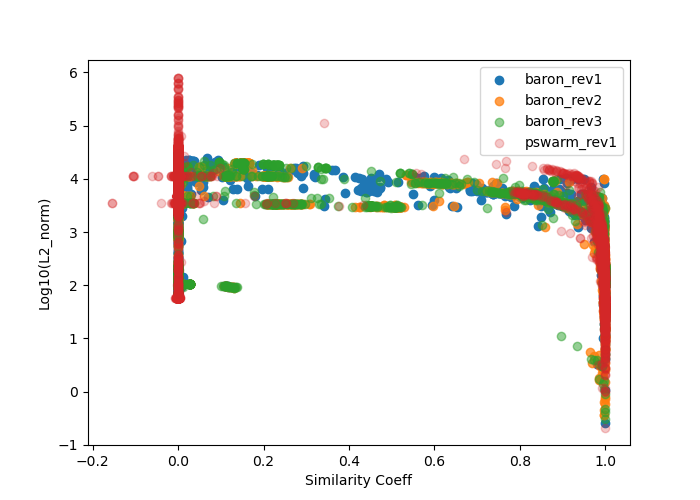

In [ ]:

figure(figsize=(7,5))
a = 1
for key in fit_names:
    # scatter(np.log10(fit_sim_L2_pairs[key][:,0]),np.log10(fit_sim_L2_pairs[key][:,1]), label=key,alpha=a)
    scatter(fit_sim_L2_pairs[key][:,0],np.log10(fit_sim_L2_pairs[key][:,1]), label=key,alpha=a)
    a += -0.25

legend()
ylabel("Log10(L2_norm)")
xlabel("Similarity Coeff")
# xlim([-10,50])
# ylim([-10,40000])

In [ ]:
# np.shape(np.append(4, resonance_similarity_matrix.flatten()))
np.append(4, resonance_similarity_matrix.flatten())


array([ 4.00000000e+00,  9.07358887e-01,  1.97514650e-06, -1.26669658e-06,
       -3.54919349e-06, -1.66676159e-05,  3.66944312e-05,  2.24937849e-05,
        1.50788353e-05, -9.86117255e-07,  1.08366546e-04,  7.86015841e-04,
        7.92449286e-01])

In [ ]:
def calc_total_L2norm(case_file, isample, fit_name):

    return fits[key].integral_FoMs['fit_theo_MSE']



isample
0       7593.867342
1      38620.341222
2      19695.122462
3      27819.196236
4      18748.839684
           ...     
495     9566.730644
496    34049.786553
497    27211.139881
498    16685.823432
499    64094.267702
Name: fit_theo_MSE, Length: 500, dtype: float64

In [ ]:
fit_names = ['baron_rev1','baron_rev2','baron_rev3', 'pswarm_rev1']

fit_simL2_mat = {}
for fit in fit_names:
    L2_norms = fits[fit].integral_FoMs['fit_theo_MSE']
    fit_simL2_mat[fit] = []
    # filename = f'/Users/noahwalton/Documents/GitHub/ATARI/examples/{fit}_simL2.csv'
    for i in range(min(dataset_range), max(dataset_range)):
        resonance_similarity_matrix, L2_norm_matrix, pairs = calc_sim_L2_matrix(case_file, i, fit)
        row = np.append(L2_norms[i], resonance_similarity_matrix.flatten())
        fit_simL2_mat[fit].append(row)
        # with open(filename, 'a') as f:
        #     f.write(f"{','.join(row)}\n")



TypeError: sequence item 0: expected str instance, numpy.float64 found

In [ ]:
# np.shape(fit_simL2_mat['baron_rev3'][1])

# np.savetxt('/Users/noahwalton/Documents/GitHub/ATARI/examples/baron_rev3_simL2.csv', fit_simL2_mat['baron_rev3'], delimiter = ',')
# fit_simL2_mat['baron_rev3'].tofile('/Users/noahwalton/Documents/GitHub/ATARI/examples/baron_rev3_simL2.csv', sep=',')
# fit_simL2_mat
# import csv

with open('/Users/noahwalton/Documents/GitHub/ATARI/examples/pswarm_rev1_simL2.csv', 'w') as f:
    mywriter = csv.writer(f, delimiter=',')
    mywriter.writerows(fit_simL2_mat['pswarm_rev1']) 


In [ ]:
fit_names = ['baron_rev1_pp','baron_rev2_pp','baron_rev3_pp', 'pswarm_rev1_pp']

fit_sim_L2_pairs = {}
for fit in fit_names:
    fit_sim_L2_pairs[fit] = np.empty((max(dataset_range), 2))
    for i in range(min(dataset_range), max(dataset_range)):
        resonance_similarity_matrix, L2_norm_matrix, pairs = calc_sim_L2_matrix(case_file, i, fit)
        if i == 0:
            sim_L2_pairs = pairs
        else:
            sim_L2_pairs = np.concatenate((sim_L2_pairs,pairs), axis=0)
    fit_sim_L2_pairs[fit] = sim_L2_pairs

Text(0.5, 0, 'Similarity Coeff')

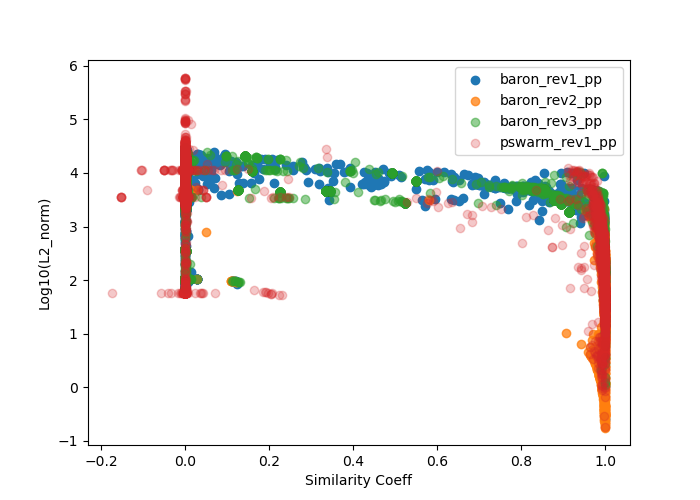

In [ ]:
figure(figsize=(7,5))
a = 1
for key in fit_names:
    # scatter(np.log10(fit_sim_L2_pairs[key][:,0]),np.log10(fit_sim_L2_pairs[key][:,1]), label=key,alpha=a)
    scatter(fit_sim_L2_pairs[key][:,0],np.log10(fit_sim_L2_pairs[key][:,1]), label=key,alpha=a)
    a += -0.25

legend()
ylabel("Log10(L2_norm)")
xlabel("Similarity Coeff")

In [ ]:

# for i in range(len(est_par_df_nonzero)):
# i = 2
# single_resonance_df = theo_par_df.loc[[i]]

# minE = single_resonance_df.E-(single_resonance_df.gnx2+single_resonance_df.Gg)*5e-3
# maxE = single_resonance_df.E+(single_resonance_df.gnx2+single_resonance_df.Gg)*5e-3
# E_pm_3Gggnx2 = theo_pw_df.E[ (theo_pw_df.E > minE.item()) & (theo_pw_df.E < maxE.item())]

# xs_tot, xs_scat, xs_cap = syndat.scattering_theory.SLBW(E_pm_3Gggnx2, Ta_pair, single_resonance_df)


# convolution = signal.fftconvolve(theo_pw_df.est_xs_pswarm_rev1, xs_tot, 'same')
# fig, ax = subplots(2,1, sharex=True)
# ax[0].plot(theo_pw_df.E, convolution)
# ax[0].set_yscale('log')

# ax[1].plot(theo_pw_df.E, theo_pw_df.est_xs_pswarm_rev1, 'r')
# ax[1].plot(E_pm_3Gggnx2, xs_tot, 'g')
# # ax[1].plot(theo_pw_df.E, theo_pw_df.theo_xs, 'g')
# ax[1].set_yscale('log')

In [ ]:
# window_cardinality_difference = len(theo_par_df.E) - len(est_par_df_nonzero.E)
# print(window_cardinality_difference)
# print(theo_par_df.E - est_par_df_nonzero.E)


0
0     0.601551
1    10.501118
2    11.144585
3     4.284263
Name: E, dtype: float64


In [ ]:
# exp_pw_df, theo_pw_df, theo_par_df, est_par_df, exp_cov = pf.sample_case.read_sample_case_data(case_file, isample, fit_name)

# avg_gnx2 = np.mean(est_par_df.gnx2)
# avg_Gg = np.mean(est_par_df.Gg)

In [ ]:
# xs_tot_syndat, xs_tot_fit, new_egrid = pf.sample_case.calculate_xs(pw_data.E, Ta_pair, syndat_par_df, fit_par_df, True)

# n = exp.redpar.val.n  # atoms per barn or atoms/(1e-12*cm^2)
# trans_fit = np.exp(-n*xs_tot_fit)
# trans_syndat = np.exp(-n*xs_tot_syndat)

# from scipy import integrate
# est_sol_SE = integrate.trapezoid((xs_tot_syndat-xs_tot_fit)**2, new_egrid)
# print(est_sol_SE)

# print(syndat_par_df)
# print(fit_par_df)

# fig, ax = subplots(1,2, figsize=(10,4))
# ax[0].plot(new_egrid, xs_tot_fit)
# ax[0].plot(new_egrid, xs_tot_syndat)
# ax[0].set_yscale('log')

# ax[1].plot(new_egrid, trans_fit, 'r')
# ax[1].plot(new_egrid, trans_syndat, 'g')